In [1]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil, sqrt
import random


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn

warnings.filterwarnings('ignore')
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.use_deterministic_algorithms(True)
#Сброс ограничений на число столбцов
#pd.options.display.max_columns = None
RANDOM_STATE=12345

In [143]:
import requests
TOKEN = "6015117129:AAGCdFJKD8mCoJc3CdMN-4b7ktiEbhpAsYA"
url = f"https://api.telegram.org/bot6015117129:AAGCdFJKD8mCoJc3CdMN-4b7ktiEbhpAsYA/getUpdates"
print(requests.get(url).json())

TOKEN = "6015117129:AAGCdFJKD8mCoJc3CdMN-4b7ktiEbhpAsYA"
chat_id = "916785354"
message = "Done!"
url = f"https://api.telegram.org/bot6015117129:AAGCdFJKD8mCoJc3CdMN-4b7ktiEbhpAsYA/sendMessage?chat_id=916785354&text=Done!"

{'ok': True, 'result': []}


## Загрузка данных

In [2]:
#df = pd.read_excel('stars.xlsx', sheet_name='stars')


df = pd.read_csv('stars.csv', sep='\t')
#df = pd.read_csv('/datasets/6_class.csv')

## Предобработка и анализ данных

In [3]:
df

Unnamed: 0.1  Unnamed: 0  Temperature (K)  Luminosity(L/Lo)  \
0               0           0             3068          0.002400   
1               1           1             3042          0.000500   
2               2           2             2600          0.000300   
3               3           3             2800          0.000200   
4               4           4             1939          0.000138   
..            ...         ...              ...               ...   
235           235         235            38940     374830.000000   
236           236         236            30839     834042.000000   
237           237         237             8829     537493.000000   
238           238         238             9235     404940.000000   
239           239         239            37882     294903.000000   

     Radius(R/Ro)  Absolute magnitude(Mv)  Star type Star color  
0          0.1700                   16.12          0        Red  
1          0.1542                   16.60          0        Red  
2          0.1020                   18.70          0        Red  
3          0.1600                   16.65          0        Red  
4          0.1030                   20.06          0        Red  
..            ...                     ...        ...        ...  
235     1356.0000                   -9.93          5       Blue  
236     1194.0000                  -10.63          5       Blue  
237     1423.0000                  -10.73          5      White  
238     1112.0000                  -11.23          5      White  
239     1783.0000                   -7.80          5       Blue  

[240 rows x 8 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0.1            240 non-null    int64  
 1   Unnamed: 0              240 non-null    int64  
 2   Temperature (K)         240 non-null    int64  
 3   Luminosity(L/Lo)        240 non-null    float64
 4   Radius(R/Ro)            240 non-null    float64
 5   Absolute magnitude(Mv)  240 non-null    float64
 6   Star type               240 non-null    int64  
 7   Star color              240 non-null    object 
dtypes: float64(3), int64(4), object(1)
memory usage: 15.1+ KB


Без пропусков - это прекрасно. Непонятная первая колонка - без названия, целочисленная.

In [5]:
df.sample(8)

Unnamed: 0.1  Unnamed: 0  Temperature (K)  Luminosity(L/Lo)  \
232           232         232            32489      648430.00000   
30             30          30            39000      204000.00000   
216           216         216             9320          29.00000   
52             52          52             3834      272000.00000   
94             94          94             9030          45.00000   
122           122         122             3218           0.00054   
213           213         213            22012        6748.00000   
95             95          95            11250         672.00000   

     Radius(R/Ro)  Absolute magnitude(Mv)  Star type  Star color  
232       1948.50                 -10.840          5        Blue  
30          10.60                  -4.700          3        Blue  
216          1.91                   1.236          3  Blue-white  
52        1183.00                  -9.200          5         Red  
94           2.63                   1.450          3  Blue-white  
122          0.11                  20.020          0         Red  
213          6.64                  -2.550          3  Blue-white  
95           6.98                  -2.300          3  Blue-white

Первая колонка - это индекс, удалю. В последней вижу необходимость приведения слов к одинаковому написанию.

In [6]:
#df = df.drop('Unnamed: 0', axis=1)

df = df.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

In [7]:
df.describe()

Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  \
count       240.000000        240.000000    240.000000   
mean      10497.462500     107188.361635    237.157781   
std        9552.425037     179432.244940    517.155763   
min        1939.000000          0.000080      0.008400   
25%        3344.250000          0.000865      0.102750   
50%        5776.000000          0.070500      0.762500   
75%       15055.500000     198050.000000     42.750000   
max       40000.000000     849420.000000   1948.500000   

       Absolute magnitude(Mv)   Star type  
count              240.000000  240.000000  
mean                 4.382396    2.500000  
std                 10.532512    1.711394  
min                -11.920000    0.000000  
25%                 -6.232500    1.000000  
50%                  8.313000    2.500000  
75%                 13.697500    4.000000  
max                 20.060000    5.000000

В этих данных категории в колонке 'Star type' и 'Star color'. Со 'Star type' будет коррелировать абсолютно всё, потому что типы как раз выделяются за счёт группировки объектов в кластеры, так можно сказать. И у каждого кластера определённые параметры.

Рассмотрим значения цветов. Вызывают сомнения 'yellowish' и сложные цвета. Оказывается, "желтоватый" вполне нормальный термин, а "Blue-white" и "Blue white" не одинаковые цвета в таблицах классификации (можно ознакомиться, например, здесь => https://kosmosgid.ru/zvyozdy/klassi-zvezd). Однако, у конкретной звезды должен быть один цвет, поэтому считаю уместным в двойных словах ставить тире. Нам дано, что этот параметр определён по спектру, а не по таблице классификации, поэтому должен быть однозначным. 

In [8]:
df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'yellowish',
       'Yellowish', 'Orange-Red', 'Blue-White'], dtype=object)

In [9]:
star_color = {
'Red':'red', 
'Blue White':'blue-white', 
'White':'white', 
'Yellowish White':'yellowish-white', 
'Blue white':'blue-white',
'Pale yellow orange':'yellow-orange', 
'Blue':'blue', 
'Blue-white':'blue-white', 
'Whitish':'whitish',
'yellow-white':'yellow-white', 
'Orange':'orange', 
'White-Yellow':'yellow-white', 
'Blue ':'blue',
'Yellowish':'yellowish', 
'Orange-Red':'orange-red', 
'Blue white ':'blue-white',
'Blue-White':'blue-white' }  
df['Star color'] = df['Star color'].replace(star_color)
df['Star color'].unique()

array(['red', 'blue-white', 'white', 'yellowish-white', 'yellow-orange',
       'blue', 'whitish', 'yellow-white', 'orange', 'yellowish',
       'orange-red'], dtype=object)

In [10]:
df.groupby('Star color').agg({'Temperature (K)':['min','max','count']})

Temperature (K)             
                            min    max count
Star color                                  
blue                       5752  40000    56
blue-white                 8570  30000    41
orange                     3749   4287     2
orange-red                 5112   5112     1
red                        1939   6850   112
white                      7220  14732    10
whitish                    8052   9700     2
yellow-orange              7230   7230     1
yellow-white               5300   8250     9
yellowish                  4077   4980     3
yellowish-white            7700  12990     3

В каких-то категориях будет маловато объектов, но таковы данные. 

In [11]:
df.duplicated().sum()

0

Дубли отсутствуют.

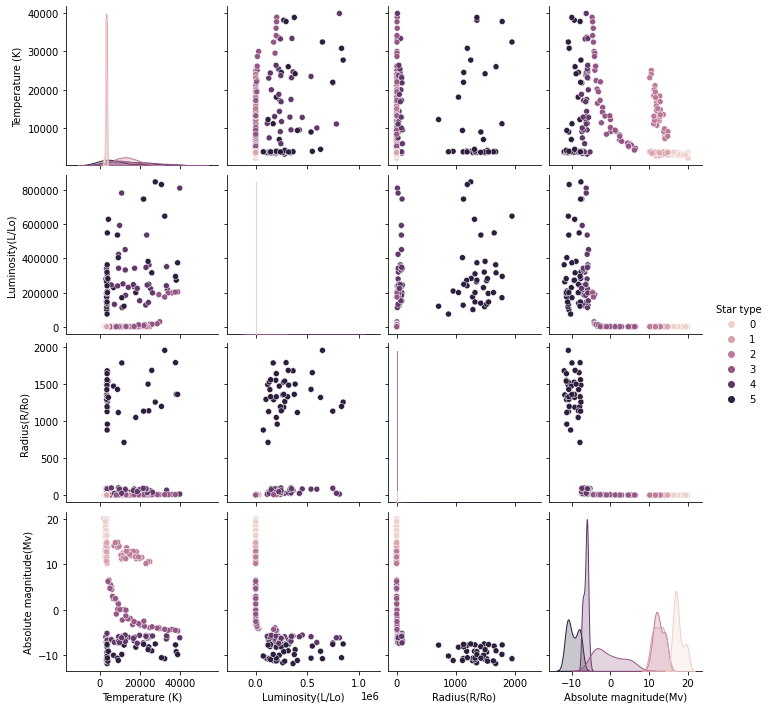

In [12]:
sns.pairplot(df, hue='Star type');

Между абсолютными температурой и звёздной величиной вырисовывается известная зависимость Герцшпрунга-Рассела(спектр/светимость) с главной последовательностью и областями гигантов и молодых звёзд. 
Радиус нам показывает, что в большинстве звёзды сравнимы с нашим Солнцем и только гипергиганты занимают большую площадь графиков (имеют сильный разброс значений радиуса). 
Также гипергиганты и сверхгиганты имеют отрицательную абсолютную звёздную величину и группируются в левой части графика.
В светимости тоже видим разброс значений для сверхгигантов и гипергигантов, но также и звёзды главной последовательности при высоких температурах могут демонстрировать разнообразие значений светимости. 

In [13]:
columns = df.columns


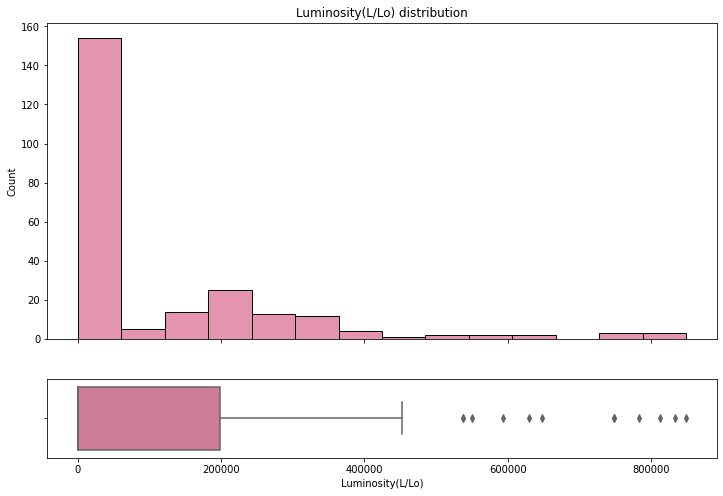

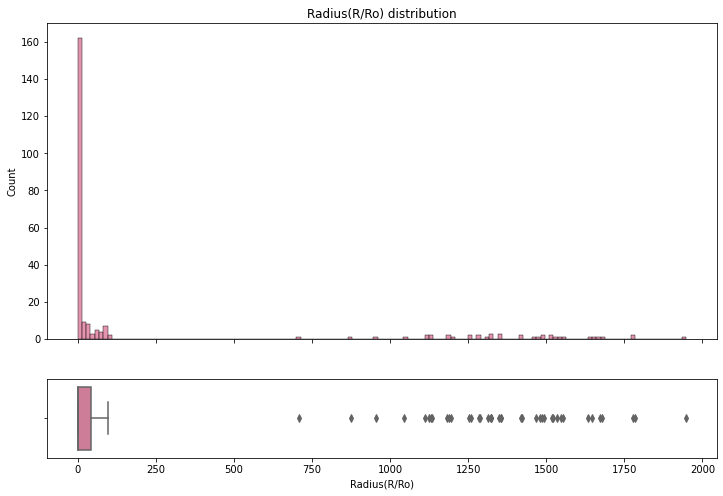

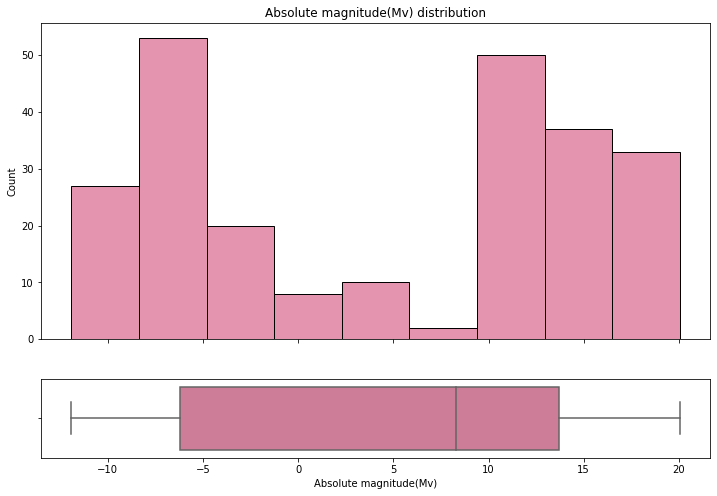

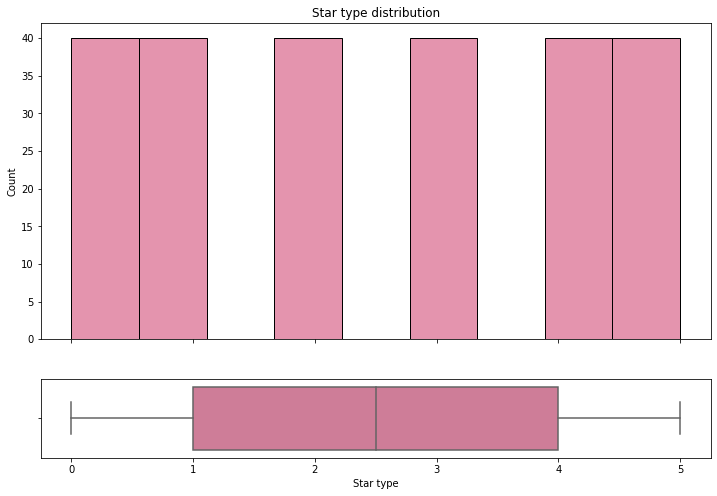

In [14]:
for i in columns[1:-1]:
    fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

    sns.histplot(x=df[i], ax=ax_hist, color='palevioletred')
    sns.boxplot(x=df[i], ax=ax_box, color='palevioletred')

    ax_box.set(xlabel=i)
    ax_hist.set(ylabel='Count')
    ax_hist.set(title=i+' distribution')
    plt.show()


  

Все типы представлены равным количеством звёзд, и при этом их характеристики разнообразны.
Светимость в основном низкая с небольшим всплеском в первой четверти, радиус маленький, с промежутком между гигантами и остальными, а звёздная величина имеет два максимума.

Рассмотрим целевой признак.

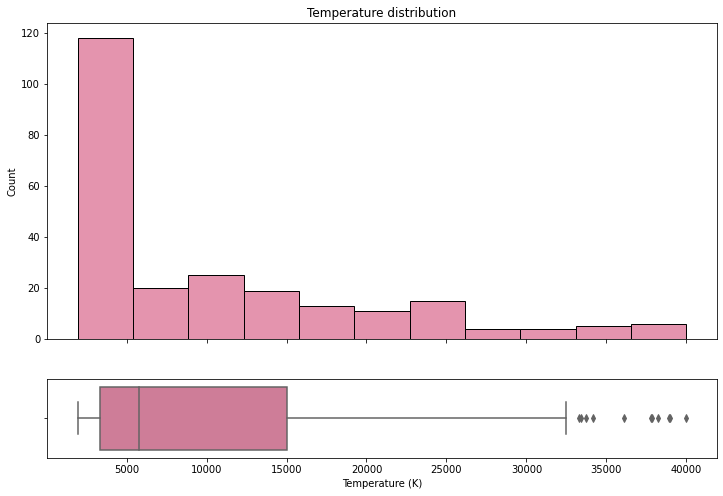

In [15]:

fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

sns.histplot(x=df['Temperature (K)'], ax=ax_hist, color='palevioletred')
sns.boxplot(x=df['Temperature (K)'], ax=ax_box, color='palevioletred')

ax_box.set(xlabel='Temperature (K)')
ax_hist.set(ylabel='Count')
ax_hist.set(title='Temperature distribution')
plt.show()

Основная масса звёзд приходится на низкие температуры и медленное горение, что примерно соответствует ситуации в общем (http://www.astronet.ru/db/msg/1177040/chapter7_05.html - до 90% звёзд относятся к нормальным) . Особенные звёзды не будем отбрасывать - данных мало, и такие объекты действительно обнаружены.

Посмотрим, что показывает матрица корреляций.

<AxesSubplot:>

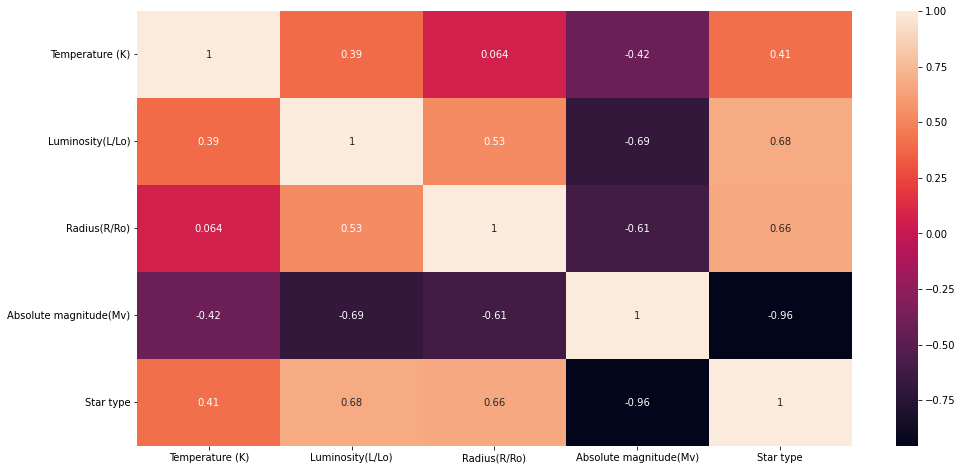

In [16]:
correlation_matrix = df.corr()

plt.figure(figsize= (16, 8))
sns.heatmap(correlation_matrix, annot = True)

Температура напрямую коррелирует со светимостью и типом звезды, и обратно коррелирует с абсолютной звёздной величиной.

Абсолютная звёздная величина показывает обратную зависимость от всех признаков, особенно сильно связана с типом звезды, и это действительно так.

Надо перевести значения колонки 'Star type' в строки, иначе дальше не хочет кодировщик обрабатывать числа как категории.

In [17]:
df['Star type'] = df['Star type'].astype('str')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    object 
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


Теперь нужно разделить данные на таргет и фичи, на обучающую, тестовую и валидационную выборки.

Отделяю 30 процентов на тест и валидацию, остальное оставляю сети на обучение.

In [19]:
X = df.drop('Temperature (K)', axis=1)
y = df['Temperature (K)']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, random_state=RANDOM_STATE, shuffle=True)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, train_size=0.5, random_state=RANDOM_STATE, shuffle=True)

In [20]:
what_words = ['Тренировочных признаков','Тренировочных целей', 'Тестовых признаков', 
        'Тестовых целей','Валидационных признаков', 'Валидационных целей']
what_arrs = [y_train, X_train, y_test, X_test, y_valid, X_valid]

for i in range(len(what_words)):
    print(f'{what_words[i]} {what_arrs[i].shape[0]*100/df.shape[0]:.0f}% от общей выборки.')

Тренировочных признаков 70% от общей выборки.
Тренировочных целей 70% от общей выборки.
Тестовых признаков 15% от общей выборки.
Тестовых целей 15% от общей выборки.
Валидационных признаков 15% от общей выборки.
Валидационных целей 15% от общей выборки.


Теперь нужно закодировать категориальные данные и масштабировать численные.

In [21]:
columns


Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [22]:
numcol = ['Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)']
catcol = ['Star type', 'Star color']

OHE для категорий, StandartScaler для чисел.

In [23]:
# .reset_index(inplace='True')

In [24]:
ohe = OneHotEncoder(sparse=False, drop = 'first', handle_unknown = 'error')

In [25]:
ohe = ohe.fit(df[catcol])

In [26]:
#X_train.reset_index(inplace=True)


X_train_cat = pd.DataFrame(ohe.transform(X_train[catcol]))
X_train_cat.columns = ohe.get_feature_names(catcol)
X_train.drop(catcol, axis = 1, inplace = True)
X_train_cat.index=X_train.index
X_train = pd.concat([X_train, X_train_cat], axis = 1)

In [27]:
X_test_cat = pd.DataFrame(ohe.transform(X_test[catcol]))
X_test_cat.columns = ohe.get_feature_names(catcol)
X_test.drop(catcol, axis = 1, inplace = True)
X_test_cat.index=X_test.index
X_test = pd.concat([X_test, X_test_cat], axis = 1)

In [28]:
X_valid_cat = pd.DataFrame(ohe.transform(X_valid[catcol]))
X_valid_cat.columns = ohe.get_feature_names(catcol)
X_valid.drop(catcol, axis = 1, inplace = True)
X_valid_cat.index=X_valid.index
X_valid = pd.concat([X_valid, X_valid_cat], axis = 1)

In [29]:
scaler = StandardScaler()

In [30]:
X_train[numcol] = scaler.fit_transform(X_train[numcol])
X_test[numcol] = scaler.transform(X_test[numcol])
X_valid[numcol] = scaler.transform(X_valid[numcol])

Поскольку в нейронной сети используются тензоры, переведём данные в этот тип.

In [31]:
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values)
X_valid = torch.FloatTensor(X_valid.values)
y_valid = torch.FloatTensor(y_valid.values)

In [32]:
X_train

tensor([[ 0.1610, -0.3821, -1.1489,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.7366,  1.9128, -1.5272,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5925, -0.4325,  1.1053,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.5925, -0.4327,  0.8609,  ...,  0.0000,  0.0000,  0.0000],
        [ 3.7149, -0.2387, -1.1608,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.8235, -0.2640, -1.1528,  ...,  0.0000,  0.0000,  0.0000]])

In [33]:
y_train

tensor([ 7282.,  9235.,  3484.,  9675., 12675.,  3542.,  2856.,  2914.,  3345.,
        14732.,  3463.,  3450., 17140., 21904., 13340.,  3270.,  3432., 10930.,
         2621., 16500.,  3750., 33300.,  8052., 26373.,  3625.,  3600.,  2968.,
         2600., 11900.,  3008., 12990.,  3095., 14100.,  3628., 21020.,  3625.,
        14060.,  5587.,  1939., 25390., 11790., 12098.,  3158.,  2831., 13420.,
        12010.,  5112.,  3142.,  3598., 16390.,  5300.,  3340.,  3605.,  3192.,
         2861.,  2650., 19400., 38940.,  8924., 23000.,  3225., 23092., 11567.,
         9383.,  3341., 19920.,  4015.,  3600.,  2871., 18000.,  3531., 23678.,
        26000.,  3295.,  7740., 17383., 10012.,  6380.,  3324.,  2637.,  2800.,
        15276., 25070., 12100.,  3068.,  3146.,  2835.,  3257., 13089., 12984.,
        34190.,  3752.,  3575.,  8930., 12912.,  3365.,  2983., 24490.,  7220.,
         2890.,  3550.,  3419., 13720.,  5936., 28700.,  7100.,  3212.,  3134.,
        17200., 37882., 12749., 24345., 

Данные готовы, можно приступать к построению базовой сети.

## Построение базовой нейронной сети

In [34]:
print('Входящих нейронов (параметров) сети будет', X_train.shape[1])

Входящих нейронов (параметров) сети будет 18


In [47]:
n_in_neurons = X_train.shape[1]
h1 = [20, 50, 100, 300, 500, 800, 1000, 1200, 1500, 2000]
h2 = [20, 50, 100, 300, 500, 800, 1000, 1200, 1500, 2000]
h3 = [20, 50, 100, 300, 500, 800, 1000, 1200, 1500, 2000]
n_out_neurons = 1

 

Создаю подкласс от класса nn.Module и задаю функции создания и работы сети.

Подберём количество скрытых слоёв.

In [54]:
class Model1(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(Model1, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_out_neurons)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        
        return x          



In [58]:
class Model2(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model2, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
       
        return x          



In [56]:
class Model3(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Model3, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        #x = self.act4(x)
        return x          



Выбираю функцию потерь MSE и оптимизатор.

In [93]:
#loss = nn.MSELoss()

def optimizer_make(net):
    optimizer1 = torch.optim.Adam(net.parameters(), lr=1e-3)
    optimizer2 = torch.optim.RMSprop(net.parameters(), lr=1e-3)
    return [optimizer1, optimizer2]

In [118]:
def learn_model(net, optimizer, num_epochs, batch_size, X_train, y_train, X_test, y_test,):
    loss = nn.MSELoss()
    
    num_batches = ceil(len(X_train)/batch_size)
    
    for epoch in range(num_epochs):
        
        order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
        
        optimizer.zero_grad()
        
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
    
            preds = net.forward(X_batch) 
                
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            
            if ((batch_idx + 1) % accumulation_iteration == 0) or (batch_idx + 1 == num_batches):
                
                optimizer.step()
                optimizer.zero_grad()
                
        if epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test)
            RMSE = torch.sqrt(loss(preds, y_test))
        
            return torch.detach(RMSE).numpy()

In [119]:
rmse1 = [['n_hidden_neurons_1', 'optimizer type', 'rmse']]
rmse2 = [['n_hidden_neurons_1', 'optimizer type', 'n_hidden_neurons_2', 'rmse']]
rmse3 = [['n_hidden_neurons_1', 'optimizer type', 'n_hidden_neurons_2', 'n_hidden_neurons_3', 'rmse']]
num_epochs = 200
batch_size = 40
accumulation_iteration = 5
for i in range(10):
    print('model1')
    n_hidden_neurons_1 = h1[i]
    net1 = Model1(n_in_neurons, n_hidden_neurons_1, n_out_neurons)
    optimizer_arr = optimizer_make(net1)
    for ind in range(len(optimizer_arr)): 
        optimizer = optimizer_arr[ind]
        rmse1.append([n_hidden_neurons_1, type(optimizer), 
                      learn_model(net1, optimizer_arr[ind], num_epochs, batch_size, X_train, y_train, X_test, y_test,)])
        
    for j in range (10):
        if i*j % 15 == 0:
            n_hidden_neurons_2 = h2[j] 
            print('model2')    
            net2 = Model2(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
            optimizer_arr = optimizer_make(net2)    
            for ind in range(len(optimizer_arr)): 
                optimizer = optimizer_arr[ind]
                rmse2.append([n_hidden_neurons_1, n_hidden_neurons_2, type(optimizer),
                      learn_model(net2, optimizer_arr[ind], num_epochs, batch_size, X_train, y_train, X_test, y_test,)])
        for k in range(10):
            if i*j*k % 250 == 0:
                n_hidden_neurons_3 = h3[np.random.randint(0, len(h1))]
                print('model3')
                optimizer_arr = optimizer_make(net3)
                for ind in range(len(optimizer_arr)): 
                    optimizer = optimizer_arr[ind]
                    net3 = Model3(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)
                    rmse3.append([n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, type(optimizer),
                          learn_model(net3, optimizer_arr[ind], num_epochs, batch_size, X_train, y_train, X_test, y_test,)])
  


    #net1 = Model1(n_in_neurons, n_hidden_neurons_1, n_out_neurons)
    #net2 = Model2(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
    #net3 = Model3(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)
    
            
    
    #rmse1.append([n_hidden_neurons_1, learn_model(net1, num_epochs, X_train, y_train, X_test, y_test,)])
    #rmse2.append([n_hidden_neurons_1, n_hidden_neurons_2, 
                  #learn_model(net2, num_epochs, X_train, y_train, X_test, y_test,)])
    #rmse3.append([n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, 
                  #learn_model(net3, num_epochs, X_train, y_train, X_test, y_test,)])


model1
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for

epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batc

epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration 

epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration 

epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration 

epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration 

epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration 

epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration 

epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration 

epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration 

epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration 

epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration 

epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration 

epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration 

epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration 

epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration 

epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration 

epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration 

epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration 

epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration 

epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration 

epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration 

epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration 

epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration 

epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration 

epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
a

epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_ite

epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration 

epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration 

epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration 

epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration 

epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration 

epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration 

epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration 

epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration 

epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration 

accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch

epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration 

epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration 

epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration 

epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration 

epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration 

epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration 

epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration 

epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration 

epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration 

epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration 

epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration 

epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration 

epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration 

epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration 

accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch

accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch

epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration 

accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch

epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration 

epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration 

epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration 

epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration 

epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration 

epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration 

epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration 

epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration 

accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iterati

epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123


epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125


epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133


epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132


epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123


epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127


epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumu

epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iterat

accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch

epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration 

epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration 

epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration 

epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration 

epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration 

epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration 

epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration 

epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration 

epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration 

epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration 

epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration 

epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for

epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch

epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulat

epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteratio

epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_it

epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumula

epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194


epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195


epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197


epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186


epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171


epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159


epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165


epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151


epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149


epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147


epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144


epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148


epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144


epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159


epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173


epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160


epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154


epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167


epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156


epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146


epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153


epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142


epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137


epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137


epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139


epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133


epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
ac

epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_ite

epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration 

epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration 

epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration 

epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration 

epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration 

accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch

accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch

model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for

epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration

accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulati

epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188


epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180


epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169


epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158


epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147


epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137


epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132


epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126


epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
a

epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133


epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126


epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123


accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulati

epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
a

epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_

epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration 

epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration 

epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration 

epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration 

epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration 

epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration 

epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batc

epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_it

epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for

epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch

epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_itera

epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197


epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196


epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198


epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186


epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175


epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172


epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183


epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170


epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157


epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147


epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134


epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122


epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumul

epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128


epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accu

epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_it

epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration 

epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration 

epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration 

epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration 

epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration 

epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration 

epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration 

epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch

epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration

epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch

epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration

accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model2
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batc

epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulati

epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accum

epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196


epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185


epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191


accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulati

epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172


epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166


epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162


epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160


accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulati

accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulati

epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123


epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulatio

epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_ite

accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch

epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration 

epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration 

epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration 

epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration 

accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch

epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration 

epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration 

epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration 

epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration 

epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration 

epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration 

epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration 

epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration 

epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration 

epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for bat

epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for b

epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 

epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_itera

epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194


epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190


epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183


epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170


epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157


epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144


epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133


epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122


accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_ite

epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_ite

epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration

epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124


epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138


epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127


epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170


epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191


epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_it

epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batc

epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration 

epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration fo

epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iterati

epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accu

epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191


epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185


epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175


accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulati

epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166


epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174


epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170


epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178


epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192


epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179


epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168


epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_itera

epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration 

epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration 

epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration 

epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration 

epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration 

epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration 

epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration 

epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration 

accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch

epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration 

epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration 

accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch

epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration 

epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration 

epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration 

accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch

epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration

epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration 

epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration 

epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration 

accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch

epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration 

epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_i

epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumu

epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126


epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumu

epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation

epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
ac

epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation

epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration 

epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration 

epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iter

epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration 

epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iter

epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
acc

epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122


epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134


epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143


epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133


epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138


accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulati

epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148


epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148


epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166


epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160


epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154


epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169


epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181


epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181


epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184


epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176


epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188


epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184


epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177


epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170


epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156


epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155


epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161


accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulati

epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165


epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158


epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156


epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179


epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181


epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190


epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193


epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190


epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182


epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190


epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192


epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177


epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184


accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulati

epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164


epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168


epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178


epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166


epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175


epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168


epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163


epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153


epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154


epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147


epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137


epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149


epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153


epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147


epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150


epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136


epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131


epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125


accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulati

epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130


epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumul

epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_it

epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteratio

epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration 

epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration 

epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration 

epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration 

epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration 

epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration 

epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration 

epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration 

epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration 

epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration 

epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration 

epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration 

epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration 

accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch

epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration 

epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration fo

epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for 

epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration 

epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration 

epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration 

epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration 

epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration 

epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration 

epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration 

epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration f

epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration fo

accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
ep

epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration 

epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration 

epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration 

epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration 

epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration 

epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration 

epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration 

epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration 

epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration 

epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration 

epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration 

epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration 

epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iterat

epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration 

epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration 

epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration 

epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration 

epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration 

epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration 

epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration 

epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration 

epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration 

epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration 

epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration 

epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration 

epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration 

epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration 

epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration 

epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration 

epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batc

epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for bat

epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration 

epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration f

epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration 

epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batc

epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration 

epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epo

epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198


accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumul

accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_itera

epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197


epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186


epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183


epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175


epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180


epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187


epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181


epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186


epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172


epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176


epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169


epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170


epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166


epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152


epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139


epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124


epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accum

epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_

epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration

epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration 

epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration 

epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration 

epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration 

epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for 

epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration fo

epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
a

epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189


epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179


epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169


epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155


epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141


epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127


epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumul

epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_

epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulati

epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130


accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulati

epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126


epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumu

epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteratio

epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iterat

accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batc

epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration 

epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration 

epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration 

accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch

epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration 

epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration 

epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration 

epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration 

epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration 

epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration 

epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration 

epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration 

epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration 

epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration 

epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration 

epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration 

epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration 

epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration 

accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch

epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration 

epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration 

epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration 

epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration 

epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch

epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteratio

epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation

epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194


epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184


epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172


epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164


epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160


epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147


accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulati

epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
a

epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulat

epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iter

epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration 

epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration 

epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration 

epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration 

epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration 

epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration 

epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration 

epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration 

epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration 

epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration 

epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration 

epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for ba

epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration 

epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for b

epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for 

epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration f

epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for ba

epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
acc

epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for

epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_it

epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration 

epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteratio

epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batc

epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration fo

epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration 

epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration 

epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration 

model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for

epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iterati

epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_it

epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_itera

epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197


epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196


epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
a

epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumu

accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumul

epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189


epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180


epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183


epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186


epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171


epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150


epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149


epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142


epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138


epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124


epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulat

accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batc

epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration 

epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration 

epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration 

epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration 

epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration 

epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration 

accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch

accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch

epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration 

epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration 

epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration 

epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batc

epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for ba

epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batc

epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteratio

epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_ite

epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_ite

epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
a

epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196


epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189


epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185


accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulati

epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175


epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162


epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159


epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146


accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulati

epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154


epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147


epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139


epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131


epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
a

epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulat

epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteratio

epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration 

epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration 

epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration 

epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration 

epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration 

epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration 

epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration 

epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration 

epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration 

epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration 

epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration 

epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration 

epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration 

epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration 

epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration 

epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration 

epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration f

epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch

epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iterat

epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iterati

accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_it

accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulati

epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192


epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194


epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184


epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181


epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173


epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170


epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178


accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulati

accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulati

epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166


epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153


epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulation_iteration for batch 4
epoch 155
accumulation_iteration for batch 4
epoch 156
accumulation_iteration for batch 4
epoch 157
accumulation_iteration for batch 4
epoch 158


accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139
accumulation_iteration for batch 4
epoch 140
accumulation_iteration for batch 4
epoch 141
accumulation_iteration for batch 4
epoch 142
accumulation_iteration for batch 4
epoch 143
accumulation_iteration for batch 4
epoch 144
accumulation_iteration for batch 4
epoch 145
accumulation_iteration for batch 4
epoch 146
accumulation_iteration for batch 4
epoch 147
accumulation_iteration for batch 4
epoch 148
accumulation_iteration for batch 4
epoch 149
accumulation_iteration for batch 4
epoch 150
accumulation_iteration for batch 4
epoch 151
accumulation_iteration for batch 4
epoch 152
accumulation_iteration for batch 4
epoch 153
accumulation_iteration for batch 4
epoch 154
accumulati

epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127
accumulation_iteration for batch 4
epoch 128
accumulation_iteration for batch 4
epoch 129
accumulation_iteration for batch 4
epoch 130
accumulation_iteration for batch 4
epoch 131
accumulation_iteration for batch 4
epoch 132
accumulation_iteration for batch 4
epoch 133
accumulation_iteration for batch 4
epoch 134
accumulation_iteration for batch 4
epoch 135
accumulation_iteration for batch 4
epoch 136
accumulation_iteration for batch 4
epoch 137
accumulation_iteration for batch 4
epoch 138
accumulation_iteration for batch 4
epoch 139


epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_iteration for batch 4
epoch 117
accumulation_iteration for batch 4
epoch 118
accumulation_iteration for batch 4
epoch 119
accumulation_iteration for batch 4
epoch 120
accumulation_iteration for batch 4
epoch 121
accumulation_iteration for batch 4
epoch 122
accumulation_iteration for batch 4
epoch 123
accumulation_iteration for batch 4
epoch 124
accumulation_iteration for batch 4
epoch 125
accumulation_iteration for batch 4
epoch 126
accumulation_iteration for batch 4
epoch 127


accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteration for batch 4
epoch 102
accumulation_iteration for batch 4
epoch 103
accumulation_iteration for batch 4
epoch 104
accumulation_iteration for batch 4
epoch 105
accumulation_iteration for batch 4
epoch 106
accumulation_iteration for batch 4
epoch 107
accumulation_iteration for batch 4
epoch 108
accumulation_iteration for batch 4
epoch 109
accumulation_iteration for batch 4
epoch 110
accumulation_iteration for batch 4
epoch 111
accumulation_iteration for batch 4
epoch 112
accumulation_iteration for batch 4
epoch 113
accumulation_iteration for batch 4
epoch 114
accumulation_iteration for batch 4
epoch 115
accumulation_iteration for batch 4
epoch 116
accumulation_it

epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration for batch 4
epoch 87
accumulation_iteration for batch 4
epoch 88
accumulation_iteration for batch 4
epoch 89
accumulation_iteration for batch 4
epoch 90
accumulation_iteration for batch 4
epoch 91
accumulation_iteration for batch 4
epoch 92
accumulation_iteration for batch 4
epoch 93
accumulation_iteration for batch 4
epoch 94
accumulation_iteration for batch 4
epoch 95
accumulation_iteration for batch 4
epoch 96
accumulation_iteration for batch 4
epoch 97
accumulation_iteration for batch 4
epoch 98
accumulation_iteration for batch 4
epoch 99
accumulation_iteration for batch 4
epoch 100
accumulation_iteration for batch 4
epoch 101
accumulation_iteratio

epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration for batch 4
epoch 77
accumulation_iteration for batch 4
epoch 78
accumulation_iteration for batch 4
epoch 79
accumulation_iteration for batch 4
epoch 80
accumulation_iteration for batch 4
epoch 81
accumulation_iteration for batch 4
epoch 82
accumulation_iteration for batch 4
epoch 83
accumulation_iteration for batch 4
epoch 84
accumulation_iteration for batch 4
epoch 85
accumulation_iteration for batch 4
epoch 86
accumulation_iteration 

epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration for batch 4
epoch 63
accumulation_iteration for batch 4
epoch 64
accumulation_iteration for batch 4
epoch 65
accumulation_iteration for batch 4
epoch 66
accumulation_iteration for batch 4
epoch 67
accumulation_iteration for batch 4
epoch 68
accumulation_iteration for batch 4
epoch 69
accumulation_iteration for batch 4
epoch 70
accumulation_iteration for batch 4
epoch 71
accumulation_iteration for batch 4
epoch 72
accumulation_iteration for batch 4
epoch 73
accumulation_iteration for batch 4
epoch 74
accumulation_iteration for batch 4
epoch 75
accumulation_iteration for batch 4
epoch 76
accumulation_iteration 

epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration for batch 4
epoch 49
accumulation_iteration for batch 4
epoch 50
accumulation_iteration for batch 4
epoch 51
accumulation_iteration for batch 4
epoch 52
accumulation_iteration for batch 4
epoch 53
accumulation_iteration for batch 4
epoch 54
accumulation_iteration for batch 4
epoch 55
accumulation_iteration for batch 4
epoch 56
accumulation_iteration for batch 4
epoch 57
accumulation_iteration for batch 4
epoch 58
accumulation_iteration for batch 4
epoch 59
accumulation_iteration for batch 4
epoch 60
accumulation_iteration for batch 4
epoch 61
accumulation_iteration for batch 4
epoch 62
accumulation_iteration 

epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration for batch 4
epoch 33
accumulation_iteration for batch 4
epoch 34
accumulation_iteration for batch 4
epoch 35
accumulation_iteration for batch 4
epoch 36
accumulation_iteration for batch 4
epoch 37
accumulation_iteration for batch 4
epoch 38
accumulation_iteration for batch 4
epoch 39
accumulation_iteration for batch 4
epoch 40
accumulation_iteration for batch 4
epoch 41
accumulation_iteration for batch 4
epoch 42
accumulation_iteration for batch 4
epoch 43
accumulation_iteration for batch 4
epoch 44
accumulation_iteration for batch 4
epoch 45
accumulation_iteration for batch 4
epoch 46
accumulation_iteration for batch 4
epoch 47
accumulation_iteration for batch 4
epoch 48
accumulation_iteration 

epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch 4
epoch 22
accumulation_iteration for batch 4
epoch 23
accumulation_iteration for batch 4
epoch 24
accumulation_iteration for batch 4
epoch 25
accumulation_iteration for batch 4
epoch 26
accumulation_iteration for batch 4
epoch 27
accumulation_iteration for batch 4
epoch 28
accumulation_iteration for batch 4
epoch 29
accumulation_iteration for batch 4
epoch 30
accumulation_iteration for batch 4
epoch 31
accumulation_iteration for batch 4
epoch 32
accumulation_iteration 

epoch 199
accumulation_iteration for batch 4
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumulation_iteration for batch 4
epoch 7
accumulation_iteration for batch 4
epoch 8
accumulation_iteration for batch 4
epoch 9
accumulation_iteration for batch 4
epoch 10
accumulation_iteration for batch 4
epoch 11
accumulation_iteration for batch 4
epoch 12
accumulation_iteration for batch 4
epoch 13
accumulation_iteration for batch 4
epoch 14
accumulation_iteration for batch 4
epoch 15
accumulation_iteration for batch 4
epoch 16
accumulation_iteration for batch 4
epoch 17
accumulation_iteration for batch 4
epoch 18
accumulation_iteration for batch 4
epoch 19
accumulation_iteration for batch 4
epoch 20
accumulation_iteration for batch 4
epoch 21
accumulation_iteration for batch

epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194
accumulation_iteration for batch 4
epoch 195
accumulation_iteration for batch 4
epoch 196
accumulation_iteration for batch 4
epoch 197
accumulation_iteration for batch 4
epoch 198
accumulation_iteration for batch 4
epoch 199
accumulation_iteration for batch 4
model3
epoch 0
accumulation_iteration for batch 4
epoch 1
accumulation_iteration for batch 4
epoch 2
accumulation_iteration for batch 4
epoch 3
accumulation_iteration for batch 4
epoch 4
accumulation_iteration for batch 4
epoch 5
accumulation_iteration for batch 4
epoch 6
accumul

epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179
accumulation_iteration for batch 4
epoch 180
accumulation_iteration for batch 4
epoch 181
accumulation_iteration for batch 4
epoch 182
accumulation_iteration for batch 4
epoch 183
accumulation_iteration for batch 4
epoch 184
accumulation_iteration for batch 4
epoch 185
accumulation_iteration for batch 4
epoch 186
accumulation_iteration for batch 4
epoch 187
accumulation_iteration for batch 4
epoch 188
accumulation_iteration for batch 4
epoch 189
accumulation_iteration for batch 4
epoch 190
accumulation_iteration for batch 4
epoch 191
accumulation_iteration for batch 4
epoch 192
accumulation_iteration for batch 4
epoch 193
accumulation_iteration for batch 4
epoch 194


epoch 157
accumulation_iteration for batch 4
epoch 158
accumulation_iteration for batch 4
epoch 159
accumulation_iteration for batch 4
epoch 160
accumulation_iteration for batch 4
epoch 161
accumulation_iteration for batch 4
epoch 162
accumulation_iteration for batch 4
epoch 163
accumulation_iteration for batch 4
epoch 164
accumulation_iteration for batch 4
epoch 165
accumulation_iteration for batch 4
epoch 166
accumulation_iteration for batch 4
epoch 167
accumulation_iteration for batch 4
epoch 168
accumulation_iteration for batch 4
epoch 169
accumulation_iteration for batch 4
epoch 170
accumulation_iteration for batch 4
epoch 171
accumulation_iteration for batch 4
epoch 172
accumulation_iteration for batch 4
epoch 173
accumulation_iteration for batch 4
epoch 174
accumulation_iteration for batch 4
epoch 175
accumulation_iteration for batch 4
epoch 176
accumulation_iteration for batch 4
epoch 177
accumulation_iteration for batch 4
epoch 178
accumulation_iteration for batch 4
epoch 179


In [120]:
rmse1

[['n_hidden_neurons_1', 'optimizer type', 'rmse'],
 [20, torch.optim.adam.Adam, array(15314.949, dtype=float32)],
 [20, torch.optim.rmsprop.RMSprop, array(15302.792, dtype=float32)],
 [50, torch.optim.adam.Adam, array(15312.394, dtype=float32)],
 [50, torch.optim.rmsprop.RMSprop, array(15285.346, dtype=float32)],
 [100, torch.optim.adam.Adam, array(15305.2, dtype=float32)],
 [100, torch.optim.rmsprop.RMSprop, array(15248.442, dtype=float32)],
 [300, torch.optim.adam.Adam, array(15278.949, dtype=float32)],
 [300, torch.optim.rmsprop.RMSprop, array(15107.734, dtype=float32)],
 [500, torch.optim.adam.Adam, array(15241.243, dtype=float32)],
 [500, torch.optim.rmsprop.RMSprop, array(14903.54, dtype=float32)],
 [800, torch.optim.adam.Adam, array(15186.703, dtype=float32)],
 [800, torch.optim.rmsprop.RMSprop, array(14734.204, dtype=float32)],
 [1000, torch.optim.adam.Adam, array(15128.068, dtype=float32)],
 [1000, torch.optim.rmsprop.RMSprop, array(14599.834, dtype=float32)],
 [1200, torch.op

In [121]:
rmse2

[['n_hidden_neurons_1', 'optimizer type', 'n_hidden_neurons_2', 'rmse'],
 [20,
  20,
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: None
      lr: 0.001
      maximize: False
      weight_decay: 0
  ),
  array(15294.399, dtype=float32)],
 [20,
  20,
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      differentiable: False
      eps: 1e-08
      foreach: None
      lr: 0.001
      maximize: False
      momentum: 0
      weight_decay: 0
  ),
  array(15105.863, dtype=float32)],
 [20,
  50,
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: None
      lr: 0.001
      maximize: False
      weight_decay: 0
  ),
  array(15273.589, dtype=float32)],
 [20,
  50,
  RMSprop (
  Parameter Group 0
      alpha: 0.99
     

In [122]:
rmse3

[['n_hidden_neurons_1',
  'optimizer type',
  'n_hidden_neurons_2',
  'n_hidden_neurons_3',
  'rmse'],
 [20,
  20,
  1000,
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: None
      lr: 0.001
      maximize: False
      weight_decay: 0
  ),
  array(15318.171, dtype=float32)],
 [20,
  20,
  1000,
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      differentiable: False
      eps: 1e-08
      foreach: None
      lr: 0.001
      maximize: False
      momentum: 0
      weight_decay: 0
  ),
  array(15318.096, dtype=float32)],
 [20,
  20,
  1200,
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: None
      lr: 0.001
      maximize: False
      weight_decay: 0
  ),
  array(15318.101, dtype=float32)],
 [20,
  20,
 

Нейросеть с двумя скрытыми слоями показала динамику лучше, да вообще динамику, чем другие варианты. Оптимизатор Адам разгоняется дольше, но в конце выходит всё-таки на меньшую ошибку, чем RMSprop. Посмотрим, как она предсказывает температуру звезды на графике. обучим нейросеть на лучших на текущий момент параметрах. 

In [127]:
n_hidden_neurons_1 = 2000
n_hidden_neurons_2 = 800
net = Model2(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()
num_batches = ceil(len(X_train)/batch_size)
    
for epoch in range(num_epochs):
        
    order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
        
    optimizer.zero_grad()
        
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        # получение индексов текущего батча
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
    
        preds = net.forward(X_batch) 
                
        loss_value = loss(preds, y_batch)
        loss_value.backward()
            
        if ((batch_idx + 1) % accumulation_iteration == 0) or (batch_idx + 1 == num_batches):
                
            optimizer.step()
            optimizer.zero_grad()
                
    if epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test)
        RMSE = torch.sqrt(loss(preds, y_test))
print(torch.detach(RMSE).numpy())        

10393.549


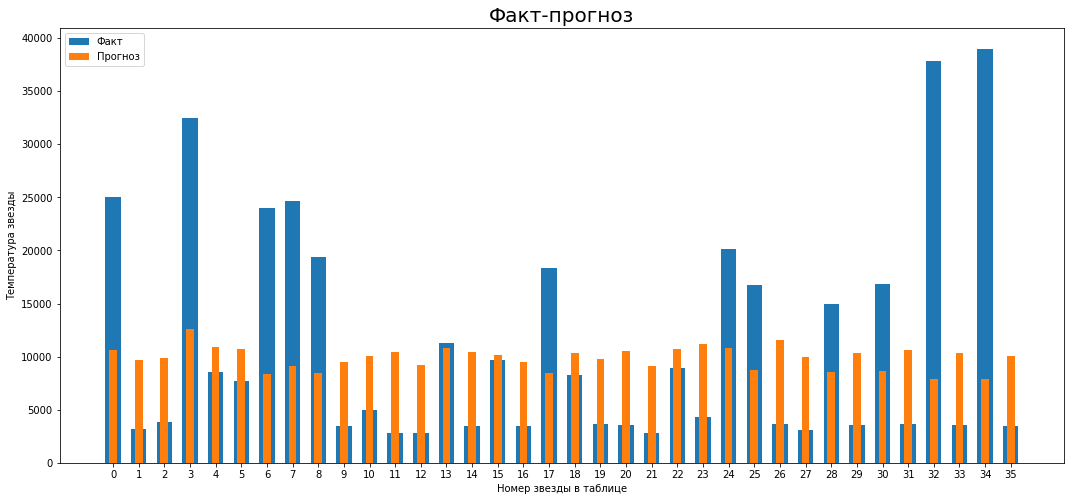

In [128]:
y1 = torch.FloatTensor(test_preds).detach().numpy().reshape([-1])
y2 = y_test.detach().numpy().reshape([-1])
x = np.arange(len(y1))

fig,ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(8)
ax.set_xticks(x)
fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
forecast = ax.bar(x, y1, width = 0.3, label = 'Прогноз')
ax.legend()
ax.set_title('Факт-прогноз', fontsize=20)
ax.set_xlabel('Номер звезды в таблице')
ax.set_ylabel('Температура звезды')
plt.show()

Как-то не очень, даже очень не. Давайте улучшим модель.

In [141]:


#del(rmse1, rmse2, rmse3, net1, optimizer_arr, i, j, k, ind, Model1, Model2, Model3)


{'ok': True, 'result': {'message_id': 53, 'from': {'id': 6015117129, 'is_bot': True, 'first_name': 'hi_from_jup', 'username': 'hi_from_jup_bot'}, 'chat': {'id': 916785354, 'first_name': 'Maria', 'username': 'maria_smiles', 'type': 'private'}, 'date': 1692357957, 'text': 'message'}}


NameError: name 'rmse1' is not defined

## Улучшение нейронной сети

Введём регуляризацию двух типов - нормализация батчей и отключение нейронов.

In [133]:
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, p):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp2 = nn.Dropout(p=p)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
     
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)
       
        return x     

Введём диапазоны параметров сети, которые попробуем перебрать для поиска лучшей модели и желаемой точности. (

In [154]:
p_arr = [0.8, 0.5, 0.1, 0]
lr_arr = [0.01, 0.02, 0.025, 0.03, 0.035, 0.04]
batch_size_arr = [10,20,30,40,50,60,70,80,90,100,110,120,240]
num_epochs_arr = [1000, 1500, 2000, 10000]
logs = []

In [158]:
def finding_neverland(p, lr, batch_size, num_epochs):
    
    net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, p)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.MSELoss()
    num_batches = ceil(len(X_train)/batch_size)
    
    for epoch in range(num_epochs):
        
        order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
        
        optimizer.zero_grad()
        
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
    
            preds = net.forward(X_batch) 
                
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            
            if ((batch_idx + 1) % accumulation_iteration == 0) or (batch_idx + 1 == num_batches):
                
                optimizer.step()
                optimizer.zero_grad()
                
        if epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test)
            RMSE = torch.sqrt(loss(preds, y_test))
            return [torch.detach(RMSE).numpy(), p, lr, batch_size, num_epochs]
    

In [ ]:
for p in p_arr:
    for lr in lr_arr:
        for batch_size in batch_size_arr:
            for num_epochs in num_epochs_arr:
                logs.append(finding_neverland(p, lr, batch_size, num_epochs))
                
url = f"https://api.telegram.org/bot6015117129:AAGCdFJKD8mCoJc3CdMN-4b7ktiEbhpAsYA/sendMessage?chat_id=916785354&text=all_done"
print(requests.get(url).json())

In [ ]:

print(requests.get(url).json())
pd.DataFrame(logs, columns=['RMSE', 'p', 'lr', 'batch_size', 'num_epochs'])

## Выводы